### Identifying Influential Information Sources in Communities of Facebook Groups

First, we'll import packages needed for script, add API token from the CrowdTangle dashboard you created, and add a database connection to store posts data we collect from sample groups

In [24]:
import requests
import json
import pandas as pd
import collections
from datetime import datetime, timedelta 
import time
import pyodbc 
from sqlalchemy import create_engine
from urllib.parse import urlsplit #,urlparse, parse_qs 
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt

#crowdtangle token:
token = 'your_dashboard_token'

#database connection:
connection_string = 'your_database_connection_string'
engine = create_engine(connection_string, encoding='utf8')
db = engine.connect()

Then we will create a 'get_links' function (CrowdTangle Links API wrapper) to use to get last 1,000 post shares from a 'seed' page

In [3]:
def get_links(token, link, platforms='facebook', count=1000):
    api_url_base = "https://api.crowdtangle.com/links?token="
    link_pre = '&link='
    count_pre = '&count='
    plat_pre = '&platforms='
    api_url = format(f'{api_url_base}{token}{link_pre}{link}{plat_pre}{platforms}{count_pre}{count}')
    response = requests.get(api_url)   
    if response.status_code == 200:
        return json.loads(response.content.decode('utf-8'))
    else:
        return None

Then we pass the links to the 'seed' pages from which we want to grab last 1,000 post shares to the 'get_links' function. In this case, we'll just use one Facebook page for simplicity - the Facebook page of the Republican Party (facebook.com/GOP) - but you could easily use multiple pages (see: https://github.com/mbaldassaro/tccdt/blob/main/1.%20Sampling%20Facebook%20Pages%20%26%20Groups%20.ipynb)

In [4]:
gop_snowball = get_links(token, link='facebook.com/GOP') #Republican Party 

We'll take a quick peek at the names of some of the pages and groups that were drawn in our snowball sample because they have shared content from the Republican Party Facebook page (this step can be skipped, but it may be interesting!)

In [5]:
gop_snowball_sample = pd.DataFrame.from_dict(gop_snowball['result']['posts'])
gop_snowball_sample = pd.concat([gop_snowball_sample.drop(['account'], axis=1), gop_snowball_sample['account'].apply(pd.Series)], axis=1)
gop_snowball_sample.groupby(['name', 'accountType']).size().to_frame().reset_index().rename(columns={0: 'shares'}).sort_values(by='shares', ascending=False).head(10)

,name,accountType,shares
146,GOP,facebook_page,80
373,Rowan County Kentucky Republicans,facebook_page,30
160,Goodhue County Republicans,facebook_page,22
510,Yellowstone County Republican Women,facebook_group,22
463,Trump Nation,facebook_group,16
70,Cherokee County Republican Women,facebook_page,14
8,9th District GOP of Georgia,facebook_page,14
161,Governor Kay Ivey Supporters,facebook_group,13
507,"Worth County, Iowa GOP",facebook_page,11
188,Inyo County Republican Party,facebook_page,10


Looks like a pretty good snowball sample of Republican pages and groups!

Next we create a 'prep_batch' function to prepare the pages and groups that have shared posts from these pages for batch upload to the CrowdTangle dashboard we created (be sure that you have created empty lists to store these pages and groups in your CrowdTangle dashboard!)

In [6]:
def prep_batch(data, atype='pages', minsize=0, listname='null'):
    df = pd.DataFrame.from_dict(data['result']['posts'])
    df = pd.concat([df.drop(['account'], axis=1), df['account'].apply(pd.Series)], axis=1)
    df = df.groupby(['name', 'url', 'accountType']).size().to_frame().reset_index().sort_values(by=0, ascending=False)
    if atype == 'pages':
        df1 = df.loc[((df['accountType'] == 'facebook_page') & (df[0] > minsize))]
    else: #need to fix the else to set to 'groups' as an option -- not a big deal right now
        df1 = df.loc[((df['accountType'] == 'facebook_group') & (df[0] > minsize))]
    df1['List'] = listname
    df1 = df1.rename(columns={"url": "Page or Account URL"}).reset_index(drop=True)
    return df1[['Page or Account URL', 'List']] 

Since we're looking to see who is influencing discussion in Facebook groups, we're only going to prep a batch of groups for upload to CrowdTangle

In [9]:
gop_snowball_gp_batch = prep_batch(gop_snowball, atype='groups', minsize=1, listname='GOP Influencer Snowball Groups')

We'll export a CSV files for batch upload to CrowdTangle -- this will export one CSV file for batch upload.

In [10]:
gop_snowball_gp_batch.to_csv("gop_influencer_snowball_groups.csv", index=False)

Once you have uploaded these pages and groups via batch upload to CrowdTangle, we can grab posts from the snowball sample. For this example, we'll grab the last 10,000 posts from the GOP Influencer Snowball Groups sample.

We create a 'get_lists' function (CrowdTangle Lists API wrapper) to use to access all lists in the dashboard that have been created. Then we will grab the id of the list of sample groups from which you want to collect up to the last 10,000 posts.

In [11]:
def get_list_info():
    ctapi_list = 'https://api.crowdtangle.com/lists?token='
    api_url = format(f'{ctapi_list}{token}')
    response = requests.get(api_url)
    if response.status_code == 200:
        return json.loads(response.content.decode('utf-8'))
    else:
        return None
    
list_info = get_list_info()
list_info['result']['lists']

[{'id': 1490375, 'title': 'Republican Snowball Pages', 'type': 'LIST'},
 {'id': 1490376, 'title': 'Republican Snowball Groups', 'type': 'LIST'},
 {'id': 1490497, 'title': 'GA Republican Groups', 'type': 'LIST'},
 {'id': 1500468, 'title': 'RNC Snowball', 'type': 'LIST'},
 {'id': 1501381, 'title': 'Republican Community', 'type': 'LIST'},
 {'id': 1504991, 'title': 'Republican Community Pages', 'type': 'LIST'},
 {'id': 1519020, 'title': 'GOP Influencer Snowball Groups', 'type': 'LIST'}]

The list id for the GOP Influencer Snowball Groups sample we just created is '1519020'.

We create a 'get_posts' function (CrowdTangle Posts API wrapper) to get up to last 10,000 posts from sample during date range provided.

We'll set a custom date range even though we will only get the last 10,000 posts available. Since we're interested in looking at week over week changes in influencers, we'll set the date range for one week. 

In [12]:
idx = '1519020' #GOP Influencer Snowball Groups 
start = '2021-03-02' #March 2 2021
end = '2021-03-09' #March 2021
allposts = []
def get_posts():
    ctapi_posts = 'https://api.crowdtangle.com/posts?token='
    start_date = '&startDate='
    end_date = '&endDate=' 
    listids = '&listIds='
    count = '&count='
    n = '100'
    offset = '&offset='
    sortBy = '&sortBy='
    sort = 'total_interactions'
    api_url = format(f'{ctapi_posts}{token}{listids}{idx}{start_date}{start}{end_date}{end}{count}{n}{sortBy}{sort}{offset}')
    for o in range(0,10000,100):
        api_call = api_url + str(o)
        response = requests.get(api_call).json()
        time.sleep(10)
        allposts.append(response)
        print(api_call)
        
def posts_toframe(allposts):
    temp = pd.DataFrame(allposts)
    temp = pd.concat([temp.drop(['result'], axis=1), temp['result'].apply(pd.Series)], axis=1)
    temp = temp.explode('posts')
    temp = pd.concat([temp.drop(['posts'], axis=1), temp['posts'].apply(pd.Series)], axis=1)
    temp = temp.rename(columns={"subscriberCount": "initialSubscriberCount", "id": "initialId", "platformId": "initialPlatformId", "platform": "initialPlatform"})
#expand account data into individual columns
    temp = pd.concat([temp.drop(['account'], axis=1), temp['account'].apply(pd.Series)], axis=1)
#expand statistics data into invidivual columns
    temp = pd.concat([temp.drop(['statistics'], axis=1), temp['statistics'].apply(pd.Series)], axis=1)
    temp = pd.concat([temp.drop(['actual'], axis=1), temp['actual'].apply(pd.Series)], axis=1)
    temp['date'] = pd.to_datetime(temp.date)
    temp['updated'] = pd.to_datetime(temp.updated)
    temp['id'] = temp['id'].astype(object)
    temp = temp.drop(['status', 'pagination'], axis=1)
    return temp

Now we'll run the get_posts function to retrieve the last 10,000 posts. Note: to address API rate limits, the get_posts function takes 15+ minutes to run (now's a good time to brew another pot of coffee).

In [13]:
get_posts() 

https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=0
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=100
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=200
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=300
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=400
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&l

https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4500
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4600
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4700
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4800
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4900
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPa

https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9000
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9100
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9200
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9300
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519020&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9400
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPa

We'll convert the data we just obtained to a dataframe... 

In [19]:
gop_snowball_group_posts = posts_toframe(allposts)

...and take a peek at the links from Facebook that we will be working with soon to extract data about influencers. 

In [21]:
gop_snowball_links = gop_snowball_group_posts[['link']][gop_snowball_group_posts['link'].notnull()]
gop_snowball_links[gop_snowball_links['link'].str.contains(r"facebook.com")].sample(n=20, random_state=1)

,link
57,https://www.facebook.com/photo.php?fbid=295706...
34,https://www.facebook.com/youngamericasfoundati...
38,https://www.facebook.com/GOP/videos/2915113123...
40,https://www.facebook.com/drandras.aradszki/pho...
29,https://www.facebook.com/turningpointusa/photo...
50,https://www.facebook.com/cpsnewsnetwork/videos...
26,https://www.facebook.com/photo.php?fbid=367599...
31,https://www.facebook.com/photo.php?fbid=368454...
32,https://www.facebook.com/PatriotPost/photos/a....
78,https://www.facebook.com/reportingfrommybasket...


Then we'll prepare it for storage... 

In [22]:
gop_snowball_group_posts = gop_snowball_group_posts.drop([0], axis=1) #removes all columns with name '0'
gop_snowball_group_posts = gop_snowball_group_posts.drop(['expandedLinks', 'media', 'expected'], axis=1) #removes columns which have list objects as values

...and upload to our database (NB: we don't want to lose this data and have to wait 15+ minutes for get_posts() line to run again).

In [25]:
gop_snowball_group_posts.to_sql("gop_groups_snowball_posts", db, if_exists='replace', schema=None, index=False, chunksize=500)

Now we'll use social network analysis and community detection methods to identify our community of Facebook groups of interest for the purposes of evaluating who is influential in that particular community.

First, we'll create a function called 'prep_sna_group' to pre-process our data for Social Network Analysis.

This script specifically uses the Facebook assigned 'platformId' of the group as the 'target' and the handle of the 'source' of posted content to the group -- this may be content that was shared from a public Facebook page or from an inidivual Facebook account, i.e. a private Facebook user. By extracting 'sources' and 'targets', we will be able to map the degree to which groups are targeted with common sources of information.

NB: The source handle - which is either a text string from the URL of a public Facebook page (e.g. joeSmith) or a numeric identifier (e.g. 987654) of a Facebook user. It is contained in the link variable and must be parsed using url splitting techniques.

In [26]:
def prep_sna_group(data):
    #subset just key columns
    data_sub = data[['name', 'url', 'platformId', 'subscriberCount', 'link']]
    #remove rows where there is no link  value
    data_sub = data_sub[pd.notnull(data_sub['link'])]
    #remove rows where link contains 'photo.php' - there is no user id handle in those links
    data_sub = data_sub[~data_sub['link'].str.contains(r"photo.php")]
    #find + remove '/groups' in link
    data_sub['link'] = data_sub['link'].replace(to_replace=r"/groups", value='', regex=True)
    #find + remove '/photos' in link
    data_sub['link'] = data_sub['link'].replace(to_replace=r"/photos", value='', regex=True)
    #find + remove "?" in link 
    data_sub['link'] = data_sub['link'].replace(to_replace=r"\?", value='', regex=True)
    #find + remove "fbid=" in link 
    data_sub['link'] = data_sub['link'].replace(to_replace=r"fbid=", value='', regex=True)
    #find + remove '&" + everything afterwards in link 
    data_sub['link'] = data_sub['link'].replace(to_replace=r"\&.*", value='/', regex=True)
    #parse cleaned up link url to separate components into different columns
    data_sub['protocol2'], data_sub['domain2'], data_sub['path2'], data_sub['query2'], data_sub['fragment2'] = zip(*[urlsplit(i) for i in data_sub['link']])
    #keep only rows where domain is facebook.com
    data_sub = data_sub[data_sub['domain2'] == 'www.facebook.com']
    #change Facebook Id value to 'target' (this is id of the group where post was shared)
    data_sub['target'] = data_sub['platformId']
    #change path2 value to 'source' (this is the id of the user that targeted the group)
    data_sub['source'] = data_sub['path2'].str.extract(r'/\s*([^\/]*)\s*\/', expand=False)
    #add column 'group' that is the same as 'Group Name'. in some functions, space btwn Group and Name causes probs
    data_sub['group'] = data_sub['name']
    #remove any rows where 'source' is null -- probably caused by  find + remove error...to be examined 
    data_sub = data_sub[pd.notnull(data_sub['source'])].reset_index(drop=True)
    #return the final cleaned table
    return data_sub

We pass the posts data to our prep_sna_group function to obtain the 'targets' (groups) and 'sources'

In [28]:
gop_groups_pairs = prep_sna_group(gop_snowball_group_posts) 

We subset the data to get just three columns of interest: name, target and source. The name is the group (name) which corresponds to the target, which is merely a numerical identifier. Extracting the name of the group is useful for adding labels to our SNA graph. As mentioned previously, the source is the handle (text string or numeric identifier) of the original content provider for the post. Also, to make sure the data is clean for social network analysis purposes, remove any rows where the source is null.

In [29]:
gop_groups_pairs = gop_groups_pairs[['name','target','source']]
gop_groups_pairs = gop_groups_pairs[pd.notnull(gop_groups_pairs['source'])]

We'll delete any rows where the source and the target are identical. NB: this is not relevant when conducting SNAs on groups data since a group cannot act as a 'user' (a group is merely a space for users to post), but it is relevant for pages, i.e. when a user re-shares an earlier post or photo from his / her own timeline. Thus we leave it here for demonstration purposes to show how it can be done.

In [30]:
gop_groups_index = gop_groups_pairs[gop_groups_pairs['target'] == gop_groups_pairs['source']].index
gop_groups_pairs.drop(gop_groups_index, inplace=True)

One measure of strength of relationships between sources and targets is the frequency with which a given source posts to a target -- this is the 'weight' of the relationship. 

In [31]:
gop_groups_weight = pd.DataFrame(gop_groups_pairs.groupby(['name', 'target', 'source']).size().reset_index())
gop_groups_weight = gop_groups_weight.rename(columns={0: 'weight'}).reset_index(drop=True)
gop_groups_weight = gop_groups_weight.sort_values(by='weight', ascending=False).reset_index(drop=True)

We can take a peek at the most prominent information sources posted across all group posts in our snowball sample. This provides us a sense of which sources are influential across the entire sample. 

In [32]:
gop_groups_weight.groupby('source').sum().sort_values(by='weight', ascending=False).head(20)

,weight
source,
RealAmericasVoice,43
newsmax,43
PeruDMV,42
100002780167774,35
DonaldJTrumpJr,31
MarjorieTaylorGreene,27
Conservativity,24
DMLNewsApp,24
Breitbart,24


While these information sources are prominent across the entire sample of snowball groups, it's   however we're interested in extracting groups that form clusters and constitute echo-chambers. To do that, we'll need to use a community detection algorithm to partition the network into discrete and logical communities.

For our community detection algorithm, we'll create a graph object that includes all sources... 

In [34]:
G = nx.from_pandas_edgelist(gop_groups_weight, source='source', target='name', edge_attr=True)

...and then partition the communities. 

In [38]:
def community_detection(network):
    temp = community.girvan_newman(network)
    temp_top = next(temp)
    temp_next = next(temp)
    return sorted(map(sorted, temp_next))

gop_communities = community_detection(G)

Now that we created our new graph object and partitioned our communities, we'll see how many discrete, partitioned communities were found with all targets and sources in those communities.

In [39]:
for idx, i in enumerate(gop_communities):
    print(idx, len(i))

0 689
1 309
2 161
3 6
4 5
5 2


It looks like we have three pretty large communities (0, 1, and 2) that are worth exploring. We can take a look at which groups from our snowball sample are in these respective groups. 

We'll write a function to extract the names of the groups in our snowball sample (gop_snowball_group_posts) and match them to their respective communities.  

Then we'll see which snowball groups are in community 0.

In [40]:
def community_groups(communities, com_id, snowballdata):
    temp = pd.DataFrame(communities[com_id], columns=['name'])
    temp_posts = snowballdata.loc[snowballdata['name'].isin(temp['name'])]
    temp_groups = temp_posts.groupby(['name']).size().to_frame().reset_index().sort_values(by=0, ascending=False)
    temp_groups = temp_groups.rename(columns={0: 'posts'}).reset_index(drop=True)
    return temp_groups

community_groups(gop_communities, 0, gop_snowball_group_posts)

,name,posts
0,Recall Governor Pritzker,543
1,TRUMP TRUTHERS,449
2,Trump Women Landslide 2020,428
3,Stuart Varney - Conservative Economic Journalist,378
4,Patriotic Catholics for President Trump ❤️,372
5,Tucker Carlson Fan Club,365
6,Hispanics for Trump 2020 🇺🇸🇺🇸,291
7,TRUMP AMERICA FOR SAFETY AND FREEDOM,284
8,"Chad Prather Fans, Political Discussions Allow...",235
9,Trump Nation,187


This appears to be a pretty obvious and substantial community of Rebuplican Facebook groups and may be a really good community of interest for evaluating influencers shaping Repubican discourse.

For due diligence pruposes, we'll check the other two large communities just to see if there's another useful community.

In [43]:
community_groups(gop_communities, 1, gop_snowball_group_posts)

,name,posts
0,"Peruanos en DC, Maryland & Virginia (DMV)",948


Based on the name, there is no indication that this a pro-Republican group. At least one person in the group obviously shared content from the Facebook page of the Republican Party at some point.

In [42]:
community_groups(gop_communities, 2, gop_snowball_group_posts)

,name,posts
0,"Szeretem a FIDESZt,hisz nála jobb nincs!",1641


Again, based on the name, which seemingly refers to a Hungarian political party, there is no indication this is a pro-Republican group and it can be ignored for our purposes.

It appears that community 0 is a good community of Republican Facebook groups that could be analyzed longitudinally and evaluate who is influencing discourse over time.

We'll save this community of groups...

In [45]:
gop_community = community_groups(gop_communities, 0, gop_snowball_group_posts)

...then we'll grab the posts from this community from our snowball sample... 

In [47]:
gop_community_groups = gop_snowball_group_posts[gop_snowball_group_posts['name'].isin(gop_community['name'])]

...then from these posts, we'll prepare this community for batch upload to CrowdTangle and export a CSV file to do (make sure you have a list of groups in CrowdTangle that match the 'listname' you assign below)

In [48]:
def prep_batch_from_posts(data, atype='pages', minsize=0, listname='null'):
    df = data
    df = df.groupby(['name', 'url', 'accountType']).size().to_frame().reset_index().sort_values(by=0, ascending=False)
    if atype == 'pages':
        df1 = df.loc[((df['accountType'] == 'facebook_page') & (df[0] > minsize))]
    else: #need to fix the else to set to 'groups' as an option -- not a big deal right now
        df1 = df.loc[((df['accountType'] == 'facebook_group') & (df[0] > minsize))]
    df1['List'] = listname
    df1 = df1.rename(columns={"url": "Page or Account URL"}).reset_index(drop=True)
    return df1[['Page or Account URL', 'List']] 

gop_community_batch = prep_batch_from_posts(gop_community_groups, atype='groups', listname='GOP Community Groups')
gop_community_batch.to_csv("gop_community_groups.csv", index=False)

Once you have batch uploaded the community to CrowdTangle, you can use this community to evaluate which sources of information are most influential within community over a period of time. You could also update this community at any time by re-running the code to this point and uploading fresh batches of data to CrowdTangle (Don't worry about duplication - CrowdTangle will handle duplicates and will not include the same page or group twice in a list!)

After batch upload to CrowdTangle, you can find the list id using the get_list_info() function created earlier in the notebook.

In [50]:
list_info = get_list_info()
list_info['result']['lists']

[{'id': 1490375, 'title': 'Republican Snowball Pages', 'type': 'LIST'},
 {'id': 1490376, 'title': 'Republican Snowball Groups', 'type': 'LIST'},
 {'id': 1490497, 'title': 'GA Republican Groups', 'type': 'LIST'},
 {'id': 1500468, 'title': 'RNC Snowball', 'type': 'LIST'},
 {'id': 1501381, 'title': 'Republican Community', 'type': 'LIST'},
 {'id': 1504991, 'title': 'Republican Community Pages', 'type': 'LIST'},
 {'id': 1519020, 'title': 'GOP Influencer Snowball Groups', 'type': 'LIST'},
 {'id': 1519132, 'title': 'GOP Community Groups', 'type': 'LIST'}]

As you can see, the newly created GOP Community Groups list has the id '1519132'

If you wanted to maintain this community as a static community in which you can identify which sources are becoming more or less influential over time - as well as identifying new or emerging influencers, you could run the following code each week:

Step 1: Get the past week's posts from the community of groups (be sure to change the date).

In [51]:
idx = '1519132' #GOP Community Groups 
start = '2021-03-02' #March 2 2021
end = '2021-03-09' #March 2021
allposts = []
get_posts()

https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=0
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=100
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=200
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=300
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=400
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&l

https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4500
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4600
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4700
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4800
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=4900
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPa

https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9000
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9100
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9200
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9300
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPaI1g6s&listIds=1519132&startDate=2021-03-02&endDate=2021-03-09&count=100&sortBy=total_interactions&offset=9400
https://api.crowdtangle.com/posts?token=S3Bhx2kk4yZaiFKsW19PwlT04kW9azGHBPa

Step 2: Convert posts to dataframe

In [52]:
gop_community_posts = posts_toframe(allposts)

Step 3: Clean posts dataframe

In [53]:
gop_community_posts = gop_community_posts.drop([0], axis=1) #removes all columns with name '0'
gop_community_posts = gop_community_posts.drop(['expandedLinks', 'media', 'expected'], axis=1) #removes columns which have list objects as values

Step 4: Use prep_sna_group() function to isolate targets and sources

In [54]:
gop_community_pairs = prep_sna_group(gop_community_posts) 

Step 5: Subset the dataframe and rename the columns

In [56]:
gop_community_pairs = gop_community_pairs[['name','target','source']]
gop_community_pairs = gop_community_pairs[pd.notnull(gop_community_pairs['source'])]

Step 6: Get the weight of sources in the dataframe

In [57]:
gop_community_weight = pd.DataFrame(gop_community_pairs.groupby(['name', 'target', 'source']).size().reset_index())
gop_community_weight = gop_community_weight.rename(columns={0: 'weight'}).reset_index(drop=True)
gop_community_weight = gop_community_weight.sort_values(by='weight', ascending=False).reset_index(drop=True)

Step 7: Sort sources by weight to identify the top 50 most influential sources 

In [66]:
gop_community_influencers = gop_community_weight.groupby('source').sum().sort_values(by='weight', ascending=False).head(50)
gop_community_influencers = pd.DataFrame(gop_community_influencers).reset_index()
gop_community_influencers

,source,weight
0,RealAmericasVoice,43
1,newsmax,43
2,DonaldJTrumpJr,31
3,MarjorieTaylorGreene,27
4,Breitbart,24
5,Conservativity,24
6,DMLNewsApp,24
7,bennyjohnson,23
8,dan.bongino,23
9,FoxNews,22


That's it! 

Now it's ripe for visualization purposes (e.g. a very basic graph):

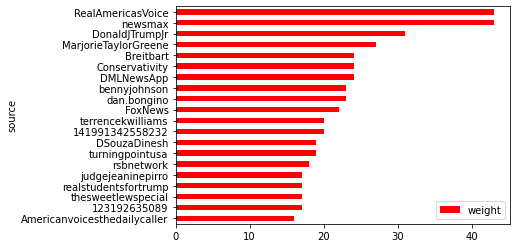

In [71]:
fig, ax = plt.subplots()
top_20 = gop_community_influencers.head(20)
top_20.plot.barh(x='source', y='weight', color='r', ax=ax).invert_yaxis()
ax.legend(["weight"])

And you could now store this data in a database (appending a new column that includes the specific date it was collected) or export it to a CSV file to enable longitudinal analysis week over week.

BONUS: 

If you wanted to track actual content shared by these influential sources on a regular basis, you could prep it for batch upload:

In [67]:
def prep_batch_influencers(data, listname):
    data['List'] = listname
    data['source'] = data['source'].astype(str)
    data['Page or Account URL'] = "https://www.facebook.com/" + data['source']
    data = data[['Page or Account URL', 'List']] 
    return data

influential_pages = prep_batch_influencers(gop_community_influencers, listname='GOP Influential Pages')
influential_pages.to_csv("influential pages.csv", index=False)